# 目标检测和边界框
:label:`sec_bbox`

前面的章节（例如 :numref:`sec_alexnet`— :numref:`sec_googlenet`）介绍了各种图像分类模型。
在图像分类任务中，我们假设图像中只有一个主要物体对象，我们只关注如何识别其类别。
然而，很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。
在计算机视觉里，我们将这类任务称为*目标检测*（object detection）或*目标识别*（object recognition）。

目标检测在多个领域中被广泛使用。
例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍物的位置来规划行进线路。
机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。

接下来的几节将介绍几种用于目标检测的深度学习方法。
我们将首先介绍目标的*位置*。


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

下面加载本节将使用的示例图像。可以看到图像左边是一只狗，右边是一只猫。
它们是这张图像里的两个主要目标。


In [24]:
from matplotlib_inline import backend_inline
def set_figsize(figsize=(5, 5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')
    d2l.plt.rcParams['figure.figsize'] = figsize

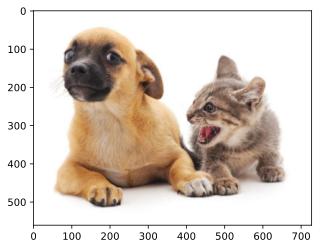

In [25]:
set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img);

## 边界框

在目标检测中，我们通常使用*边界框*（bounding box）来描述对象的空间位置。
边界框是矩形的，由矩形左上角的以及右下角的$x$和$y$坐标决定。
另一种常用的边界框表示方法是边界框中心的$(x, y)$轴坐标以及框的宽度和高度。

在这里，我们[**定义在这两种表示法之间进行转换的函数**]：`box_corner_to_center`从两角表示法转换为中心宽度表示法，而`box_center_to_corner`反之亦然。
输入参数`boxes`可以是长度为4的张量，也可以是形状为（$n$，4）的二维张量，其中$n$是边界框的数量。


In [3]:
#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

我们将根据坐标信息[**定义图像中狗和猫的边界框**]。
图像中坐标的原点是图像的左上角，向右的方向为$x$轴的正方向，向下的方向为$y$轴的正方向。


In [4]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

我们可以通过转换两次来验证边界框转换函数的正确性。


In [5]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

我们可以[**将边界框在图中画出**]，以检查其是否准确。
画之前，我们定义一个辅助函数`bbox_to_rect`。
它将边界框表示成`matplotlib`的边界框格式。


In [6]:
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

在图像上添加边界框之后，我们可以看到两个物体的主要轮廓基本上在两个框内。


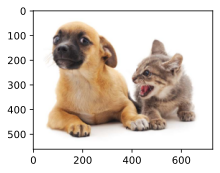

In [32]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 小结

* 目标检测不仅可以识别图像中所有感兴趣的物体，还能识别它们的位置，该位置通常由矩形边界框表示。
* 我们可以在两种常用的边界框表示（中间，宽度，高度）和（左上，右下）坐标之间进行转换。

## 练习

1. 找到另一张图像，然后尝试标记包含该对象的边界框。比较标注边界框和标注类别哪个需要更长的时间？
1. 为什么`box_corner_to_center`和`box_center_to_corner`的输入参数的最内层维度总是4？


[Discussions](https://discuss.d2l.ai/t/2944)
